# MobileNetV2 for Age and Gender Recognition
## Objective 
Fine-tune MobileNetV2 model to create lightweight version that is appropriate for edge devices, ensuring efficient performance in terms of speed and memory usage.

# Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report
import time

# Check if GPU is Active

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


# Load all Fold Files into a Single DataFrame

In [3]:
# Load the fold files into individual dataframes
fold_0 = pd.read_csv('/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt', sep='\t')
fold_1 = pd.read_csv('/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt', sep='\t')
fold_2 = pd.read_csv('/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt', sep='\t')
fold_3 = pd.read_csv('/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt', sep='\t')
fold_4 = pd.read_csv('/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt', sep='\t')

# Combine the dataframes
all_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
all_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


# Check the Shape of DataFrame

In [4]:
all_data.shape

(19370, 12)

# Extract Image Paths

In [5]:
# Define the base path to the image folder
base_path = '/kaggle/input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/'

# Function to construct and verify image path
def get_image_path(row):
    user_dir = os.path.join(base_path, row['user_id'])  # Directory based on user_id
    image_file = row['original_image']  # Image file name from the dataset
    
    # Try to match files based on the image_file substring
    if os.path.exists(user_dir):
        for file in os.listdir(user_dir):
            if image_file in file and file.lower().endswith(('.jpg', '.jpeg', '.png')):
                return os.path.join(user_dir, file)
    
    return None  # Return None if no match is found

# Add the verified image path to the DataFrame
all_data['image_path'] = all_data.apply(get_image_path, axis=1)

# Drop rows with missing image paths (invalid paths)
all_data = all_data.dropna(subset=['image_path'])

# Check the updated DataFrame
all_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,image_path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,/kaggle/input/adience-benchmark-gender-and-age...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,/kaggle/input/adience-benchmark-gender-and-age...
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,/kaggle/input/adience-benchmark-gender-and-age...
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,/kaggle/input/adience-benchmark-gender-and-age...
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,/kaggle/input/adience-benchmark-gender-and-age...


In [6]:
all_data.shape

(19370, 13)

# Data Preprocessing

## Remove Irrelavant Columns from DataFrame

In [7]:
# Drop the specified columns from the DataFrame
all_data = all_data.drop(columns=['x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'])

# Check the updated DataFrame to ensure the columns are dropped
all_data.head()

,user_id,original_image,face_id,age,gender,image_path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,/kaggle/input/adience-benchmark-gender-and-age...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,/kaggle/input/adience-benchmark-gender-and-age...
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,/kaggle/input/adience-benchmark-gender-and-age...
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,/kaggle/input/adience-benchmark-gender-and-age...
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,/kaggle/input/adience-benchmark-gender-and-age...


## Handle Missing/Null Values

In [8]:
# Check for missing values
all_data.isnull().sum()

user_id             0
original_image      0
face_id             0
age               748
gender            779
image_path          0
dtype: int64

In [9]:
# Remove missing values in age and gender columns
all_data = all_data.dropna(subset=['age', 'gender'])

In [10]:
# Check for missing values
all_data.isnull().sum()

user_id           0
original_image    0
face_id           0
age               0
gender            0
image_path        0
dtype: int64

## Encode Categorical Labels to Numerical Values

In [11]:
# Check unique values in gender
all_data['gender'].unique()

array(['f', 'm', 'u'], dtype=object)

In [12]:
# Map gender to numerical values
all_data['gender'] = all_data['gender'].map({'f': 0, 'm': 1, 'u': 2})

In [13]:
# Check unique values in age
all_data['age'].unique()

array(['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)',
       '(48, 53)', '(8, 12)', '(0, 2)', '(38, 48)', '35', '3', '55', '58',
       '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)', '(27, 32)',
       '57', '2', '29', '34', '42', '46'], dtype=object)

In [14]:
# Function to converts the age ranges and individual ages to a numeric format
def convert_age_range(age_range):
    # Handle age ranges
    if age_range == '(0, 2)':
        return 1
    elif age_range == '(4, 6)':
        return 5
    elif age_range == '(8, 12)':
        return 10
    elif age_range == '(15, 20)':
        return 18
    elif age_range == '(25, 32)':
        return 28
    elif age_range == '(27, 32)':
        return 30
    elif age_range == '(38, 43)':
        return 40
    elif age_range == '(38, 42)':
        return 40
    elif age_range == '(38, 48)':
        return 43
    elif age_range == '(48, 53)':
        return 50
    elif age_range == '(60, 100)':
        return 80 
    elif age_range == '(8, 23)':
        return 16
    
    # Handle individual ages (convert to int)
    try:
        return int(age_range)
    except ValueError:
        return None  # Handle invalid cases

In [15]:
# Apply the conversion function
all_data['age'] = all_data['age'].apply(convert_age_range)

# Check the updated DataFrame
all_data[['age', 'gender']].head()

,age,gender
0,28,0
1,28,1
2,28,0
3,28,1
4,28,1


## Preprocessing the Images

In [16]:
# Function to load and preprocess images
def preprocess_image(image_path):
    # Load the image from the path
    image = cv2.imread(image_path)
    
    # Resize the image to 128x128 (Reduce Memory)
    image_resized = cv2.resize(image, (128, 128))
    
    # Normalize pixel values to [0, 1]
    image_normalized = image_resized / 255.0
    
    return image_normalized

# Apply preprocessing to all images
all_data['preprocessed_image'] = all_data['image_path'].apply(preprocess_image)

In [17]:
all_data.head()

,user_id,original_image,face_id,age,gender,image_path,preprocessed_image
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,28,0,/kaggle/input/adience-benchmark-gender-and-age...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,28,1,/kaggle/input/adience-benchmark-gender-and-age...,"[[[0.7803921568627451, 0.8313725490196079, 0.9..."
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,28,0,/kaggle/input/adience-benchmark-gender-and-age...,"[[[0.44313725490196076, 0.6039215686274509, 0...."
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,28,1,/kaggle/input/adience-benchmark-gender-and-age...,"[[[0.44313725490196076, 0.6039215686274509, 0...."
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,28,1,/kaggle/input/adience-benchmark-gender-and-age...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


# Visualizing the Images

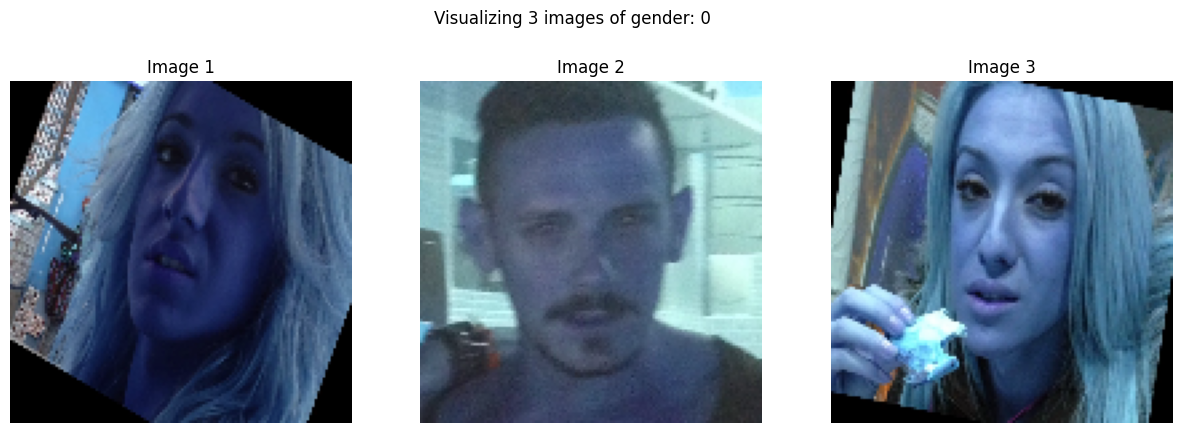

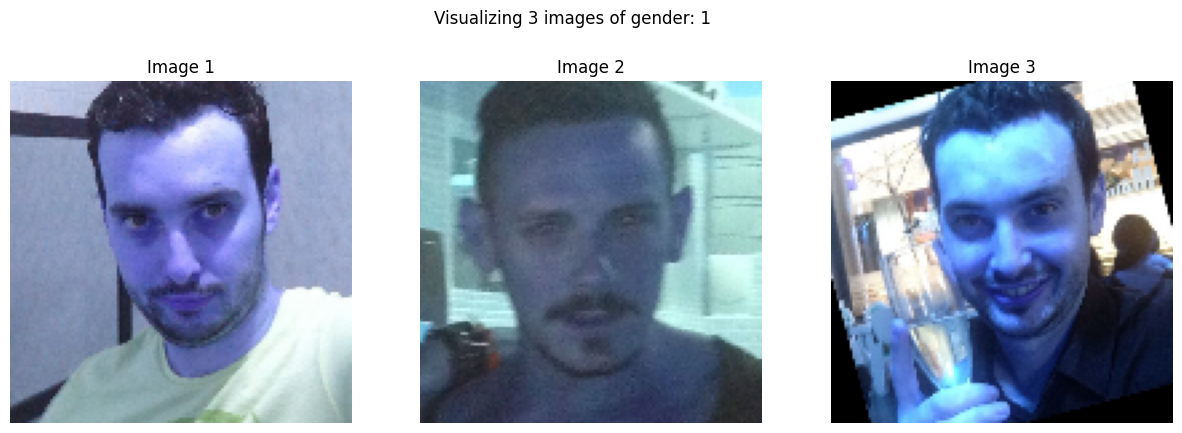

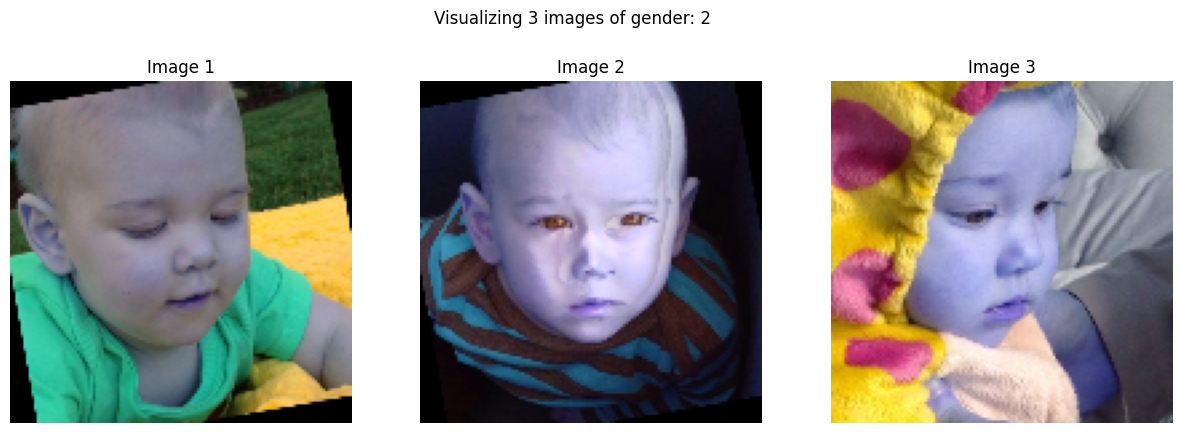

In [18]:
# Function to visualize a few images
def visualize_images(df, gender, num_images=3):
    # Filter the DataFrame for the selected gender
    gender_df = df[df['gender'] == gender].head(num_images)
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f'Visualizing {num_images} images of gender: {gender}')
    
    for i, (index, row) in enumerate(gender_df.iterrows()):
        axes[i].imshow(row['preprocessed_image'])
        axes[i].axis('off')  # Remove axis for clarity
        axes[i].set_title(f'Image {i+1}')
    
    plt.show()

# Visualize 3 images of each gender (0, 1, 2 for 'f', 'm', 'u')
for gender in [0, 1, 2]:
    visualize_images(all_data, gender, num_images=3)

# Verify the Distribution of Labels

## Checking Distribution of Gender Label

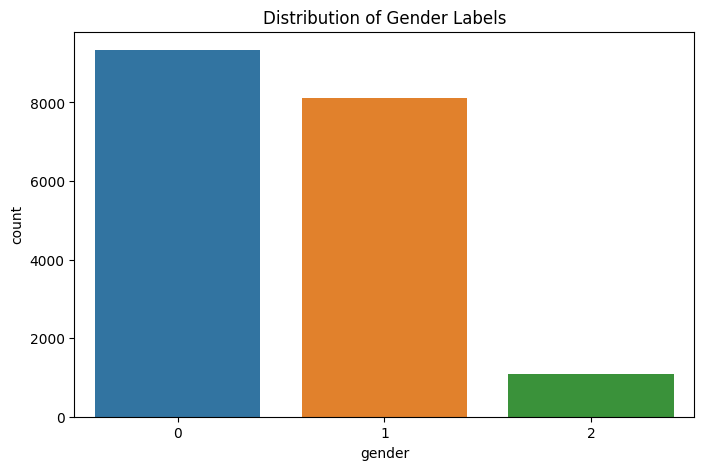

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=all_data)
plt.title('Distribution of Gender Labels')
plt.show()

## Checking Distribution of Age Label

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


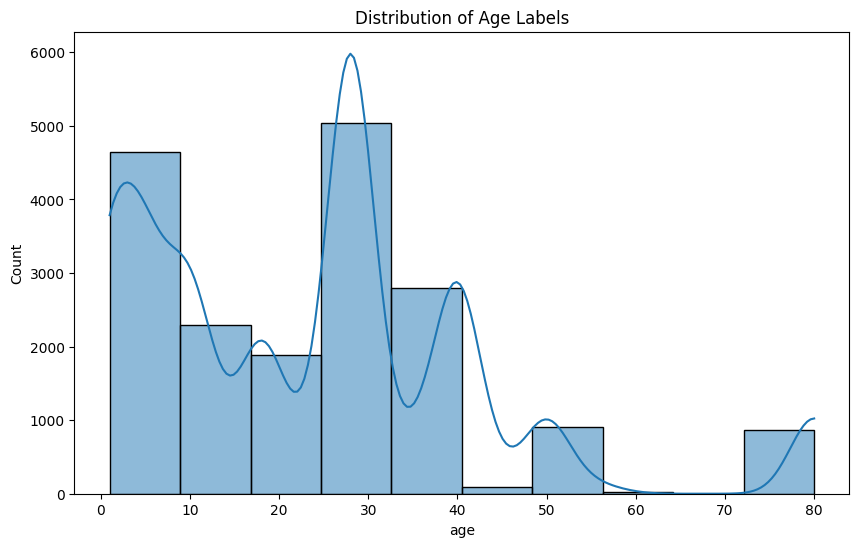

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(all_data['age'], bins=10, kde=True)
plt.title('Distribution of Age Labels')
plt.show()

# Splitting the DataFrame

In [21]:
# Prepare the image data (X) and both gender and age labels (y_gender and y_age)
X = np.array(all_data['preprocessed_image'].tolist()).astype('float16')
y_gender = np.array(all_data['gender'].tolist())
y_age = np.array(all_data['age'].tolist())

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train_gender, y_temp_gender, y_train_age, y_temp_age = train_test_split(
    X, y_gender, y_age, test_size=0.30, random_state=42
)
X_val, X_test, y_val_gender, y_test_gender, y_val_age, y_test_age = train_test_split(
    X_temp, y_temp_gender, y_temp_age, test_size=0.50, random_state=42
)

In [22]:
# Print the shapes to ensure everything is correct
print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")
print(f"Gender Training labels: {y_train_gender.shape}, Age Training labels: {y_train_age.shape}")
print(f"Gender Validation labels: {y_val_gender.shape}, Age Validation labels: {y_val_age.shape}")
print(f"Gender Test labels: {y_test_gender.shape}, Age Test labels: {y_test_age.shape}")

Training data: (12985, 128, 128, 3), Validation data: (2783, 128, 128, 3), Test data: (2783, 128, 128, 3)
Gender Training labels: (12985,), Age Training labels: (12985,)
Gender Validation labels: (2783,), Age Validation labels: (2783,)
Gender Test labels: (2783,), Age Test labels: (2783,)


# Fine-Tuning MobileNet

## MobileNetV2 Model for Multi-Task

In [23]:
# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Shared layers for both tasks (gender and age)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Gender prediction branch (binary classification)
gender_output = layers.Dense(128, activation='relu')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_output)  # Sigmoid for binary classification

# Age prediction branch (regression)
age_output = layers.Dense(128, activation='relu')(x)
age_output = layers.Dense(1, activation='linear', name='age_output')(age_output)  # Linear for regression

# Define the model
model = models.Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},  # Binary cross-entropy for gender, MSE for age
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})  # Mean Absolute Error for age
# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,178 (9.87 MB)

 Trainable params: 2,552,066 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train the Model

In [24]:
history = model.fit(X_train, {'gender_output': y_train_gender, 'age_output': y_train_age}, 
                    validation_data=(X_val, {'gender_output': y_val_gender, 'age_output': y_val_age}),
                    epochs=10, batch_size=32)

Epoch 1/10


I0000 00:00:1728741418.727787     598 service.cc:145] XLA service 0x7bedcc005f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728741418.727849     598 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728741418.727854     598 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728741425.048397     627 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 4 bytes spill stores, 4 bytes spill loads



  2/406 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - age_output_mae: 24.3475 - gender_output_accuracy: 0.4297 - loss: 961.6451   

I0000 00:00:1728741442.441938     598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


406/406 ━━━━━━━━━━━━━━━━━━━━ 102s 131ms/step - age_output_mae: 14.1362 - gender_output_accuracy: 0.5340 - loss: 414.8256 - val_age_output_mae: 10.5588 - val_gender_output_accuracy: 0.5613 - val_loss: 241.8297
Epoch 2/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - age_output_mae: 8.5051 - gender_output_accuracy: 0.6106 - loss: 156.3939 - val_age_output_mae: 10.3008 - val_gender_output_accuracy: 0.5286 - val_loss: 217.8946
Epoch 3/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - age_output_mae: 7.7000 - gender_output_accuracy: 0.6173 - loss: 128.9165 - val_age_output_mae: 10.1134 - val_gender_output_accuracy: 0.5850 - val_loss: 207.4762
Epoch 4/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - age_output_mae: 7.2989 - gender_output_accuracy: 0.6288 - loss: 108.3962 - val_age_output_mae: 9.9172 - val_gender_output_accuracy: 0.5372 - val_loss: 146.3813
Epoch 5/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - age_output_mae: 7.1439 - gender_output_accuracy: 0.6383 - loss: 37.9430 - val_age_out

## Evaluate the Model

### Plotting Training and Validation Metrics

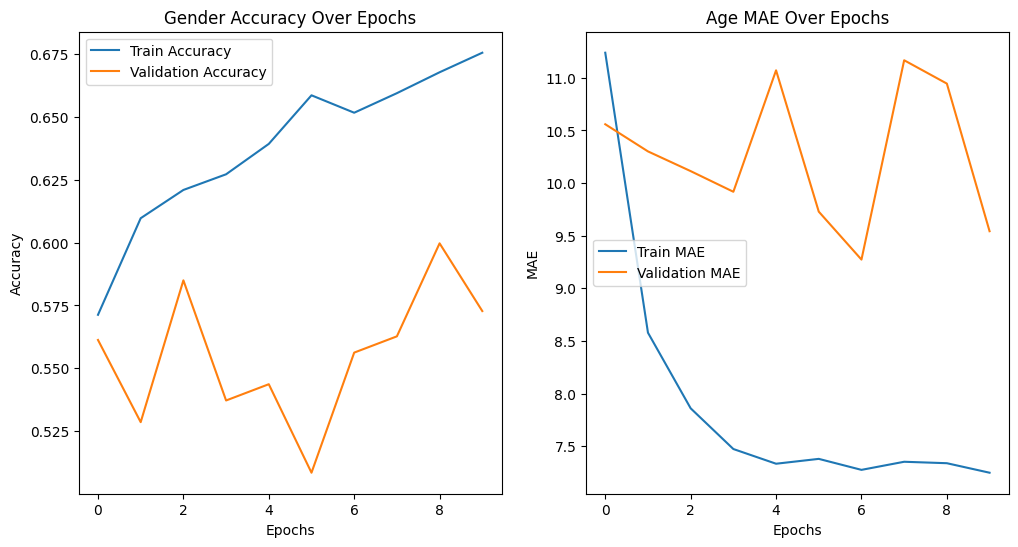

In [25]:
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    
    # Gender Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
    plt.title('Gender Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Age MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_mae'], label='Train MAE')
    plt.plot(history.history['val_age_output_mae'], label='Validation MAE')
    plt.title('Age MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

# Call the function to display plots
plot_training_history(history)

### Evaluate the model on test data

In [26]:
test_loss, test_age_mae, test_gender_acc = model.evaluate(X_test, [y_test_gender, y_test_age])

print(f"Gender Test Accuracy: {test_gender_acc:.4f}")
print(f"Age Test MAE: {test_age_mae:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - age_output_mae: 9.4445 - gender_output_accuracy: 0.5874 - loss: -877.7616
Gender Test Accuracy: 0.5929
Age Test MAE: 9.5159


### R² Score for Age Prediction

In [27]:
# Predict ages on the test set
y_pred_age = model.predict(X_test)[1]  # [1] for age_output (regression)

# Calculate R² score
r2 = r2_score(y_test_age, y_pred_age)
print(f"R² Score for Age Prediction: {r2:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step
R² Score for Age Prediction: 0.4819


### Confusion Matrix and Classification Report for Gender Prediction

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


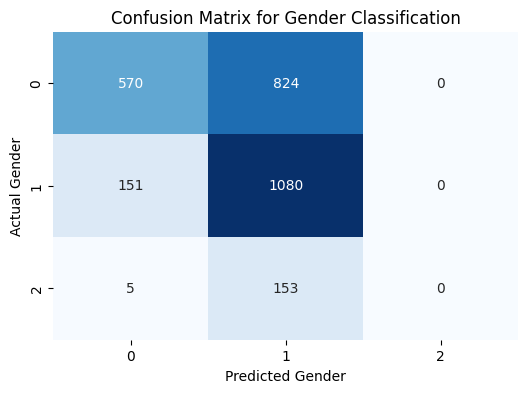

Classification Report for Gender Classification:
              precision    recall  f1-score   support

      Female       0.79      0.41      0.54      1394
        Male       0.53      0.88      0.66      1231
     Unknown       0.00      0.00      0.00       158

    accuracy                           0.59      2783
   macro avg       0.44      0.43      0.40      2783
weighted avg       0.63      0.59      0.56      2783



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Predict gender on the test set
y_pred_gender = (model.predict(X_test)[0] > 0.5).astype('int')  # [0] for gender_output

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_gender, y_pred_gender)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix for Gender Classification')
plt.ylabel('Actual Gender')
plt.xlabel('Predicted Gender')
plt.show()

# Classification Report
report = classification_report(y_test_gender, y_pred_gender, target_names=['Female', 'Male', 'Unknown'])
print("Classification Report for Gender Classification:")
print(report)

### Evaluate Inference Time

In [29]:
# Select a small sample of test data to measure inference time
sample_size = 100
X_sample = X_test[:sample_size]

# Measure inference time
start_time = time.time()
_ = model.predict(X_sample)
end_time = time.time()

# Calculate and print the average inference time per sample
inference_time = (end_time - start_time) / sample_size
print(f"Average inference time per sample: {inference_time:.6f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 
Average inference time per sample: 0.055805 seconds


### Check Memory Usage

In [30]:
# Get total trainable parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])

# Calculate memory usage in bytes (float32 -> 4 bytes per parameter)
memory_usage_bytes = trainable_params * 4  # 4 bytes per float32
memory_usage_mb = memory_usage_bytes / (1024 ** 2)  # Convert to MB

print(f"Model memory usage: {memory_usage_mb:.2f} MB")

Model memory usage: 9.74 MB


## Save the Model

In [31]:
# Save the Keras model as an .h5 file
model.save('Original_MobileNet_Age_Gender.h5')

# Provide a download link to the .h5 file
from IPython.display import FileLink

# Display a download link
FileLink('Original_MobileNet_Age_Gender.h5')

/kaggle/working/Original_MobileNet_Age_Gender.h5